In [2]:
import itertools
import numpy as np
import pandas as pd
import ultraplot as pplt
import os
import sys
import warnings

sys.path.append('../scripts/')
from drifter import compute_along_across_components
from scipy.interpolate import interp2d
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

df_ift = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv', index_col=0)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)

# Calculations
# Length scale bins need area adjustment
df_ift['area_adj_km2'] = (np.sqrt(df_ift.area) + 6)**2*.25*.25 # 6 pixel shift minimizes error against manual

edge_bins = np.arange(0, 800, 25)
df_ift['edge_bin'] = np.digitize(df_ift.edge_dist_km, bins=edge_bins)

length_bins = np.arange(0, 50, 2)
df_ift['length_scale'] = df_ift['area_adj_km2']**0.5
df_ift['length_bin'] = np.digitize(df_ift.length_scale, bins=length_bins)

In [3]:
df_ift_longer = df_ift.groupby('floe_id').filter(lambda group: group.datetime.max() - group.datetime.min() >= pd.to_timedelta(5, 'd'))

In [7]:
# Select 5-day range for each floe
# Then compute the net displacement over a 5 day window
# Each track should have daily data if it was available
df_updated = []
for floe_id, group in df_ift_longer.groupby('floe_id'):
    idx0 = group.index.values[0]
    idx1 = group.index.values[5]
    if group.datetime[idx1] - group.datetime[idx0] >= pd.to_timedelta(5, 'd'):  
        dx = group.loc[idx1, 'x_stere'] - group.loc[idx0, 'x_stere']
        dy = group.loc[idx1, 'y_stere'] - group.loc[idx0, 'y_stere']
        dt = (group.datetime.max() - group.datetime.min()).total_seconds()
        group['u_5D_ift'] = dx/dt
        group['v_5D_ift'] = dy/dt
        df_updated.append(group.loc[idx0:idx1, :].copy())
df_updated = pd.concat(df_updated)

# Drop floes which don't move at all over the 5-day period
drop_floes = df_updated.groupby('floe_id').transform('mean')

In [ ]:
df_updated = df_updated

In [12]:
U = df_updated.groupby('floe_id').transform('mean')
U = np.sqrt(U['u_5D_ift']**2 + U['v_5D_ift']**2)
df_updated = df_updated.loc[U > 1e-6]

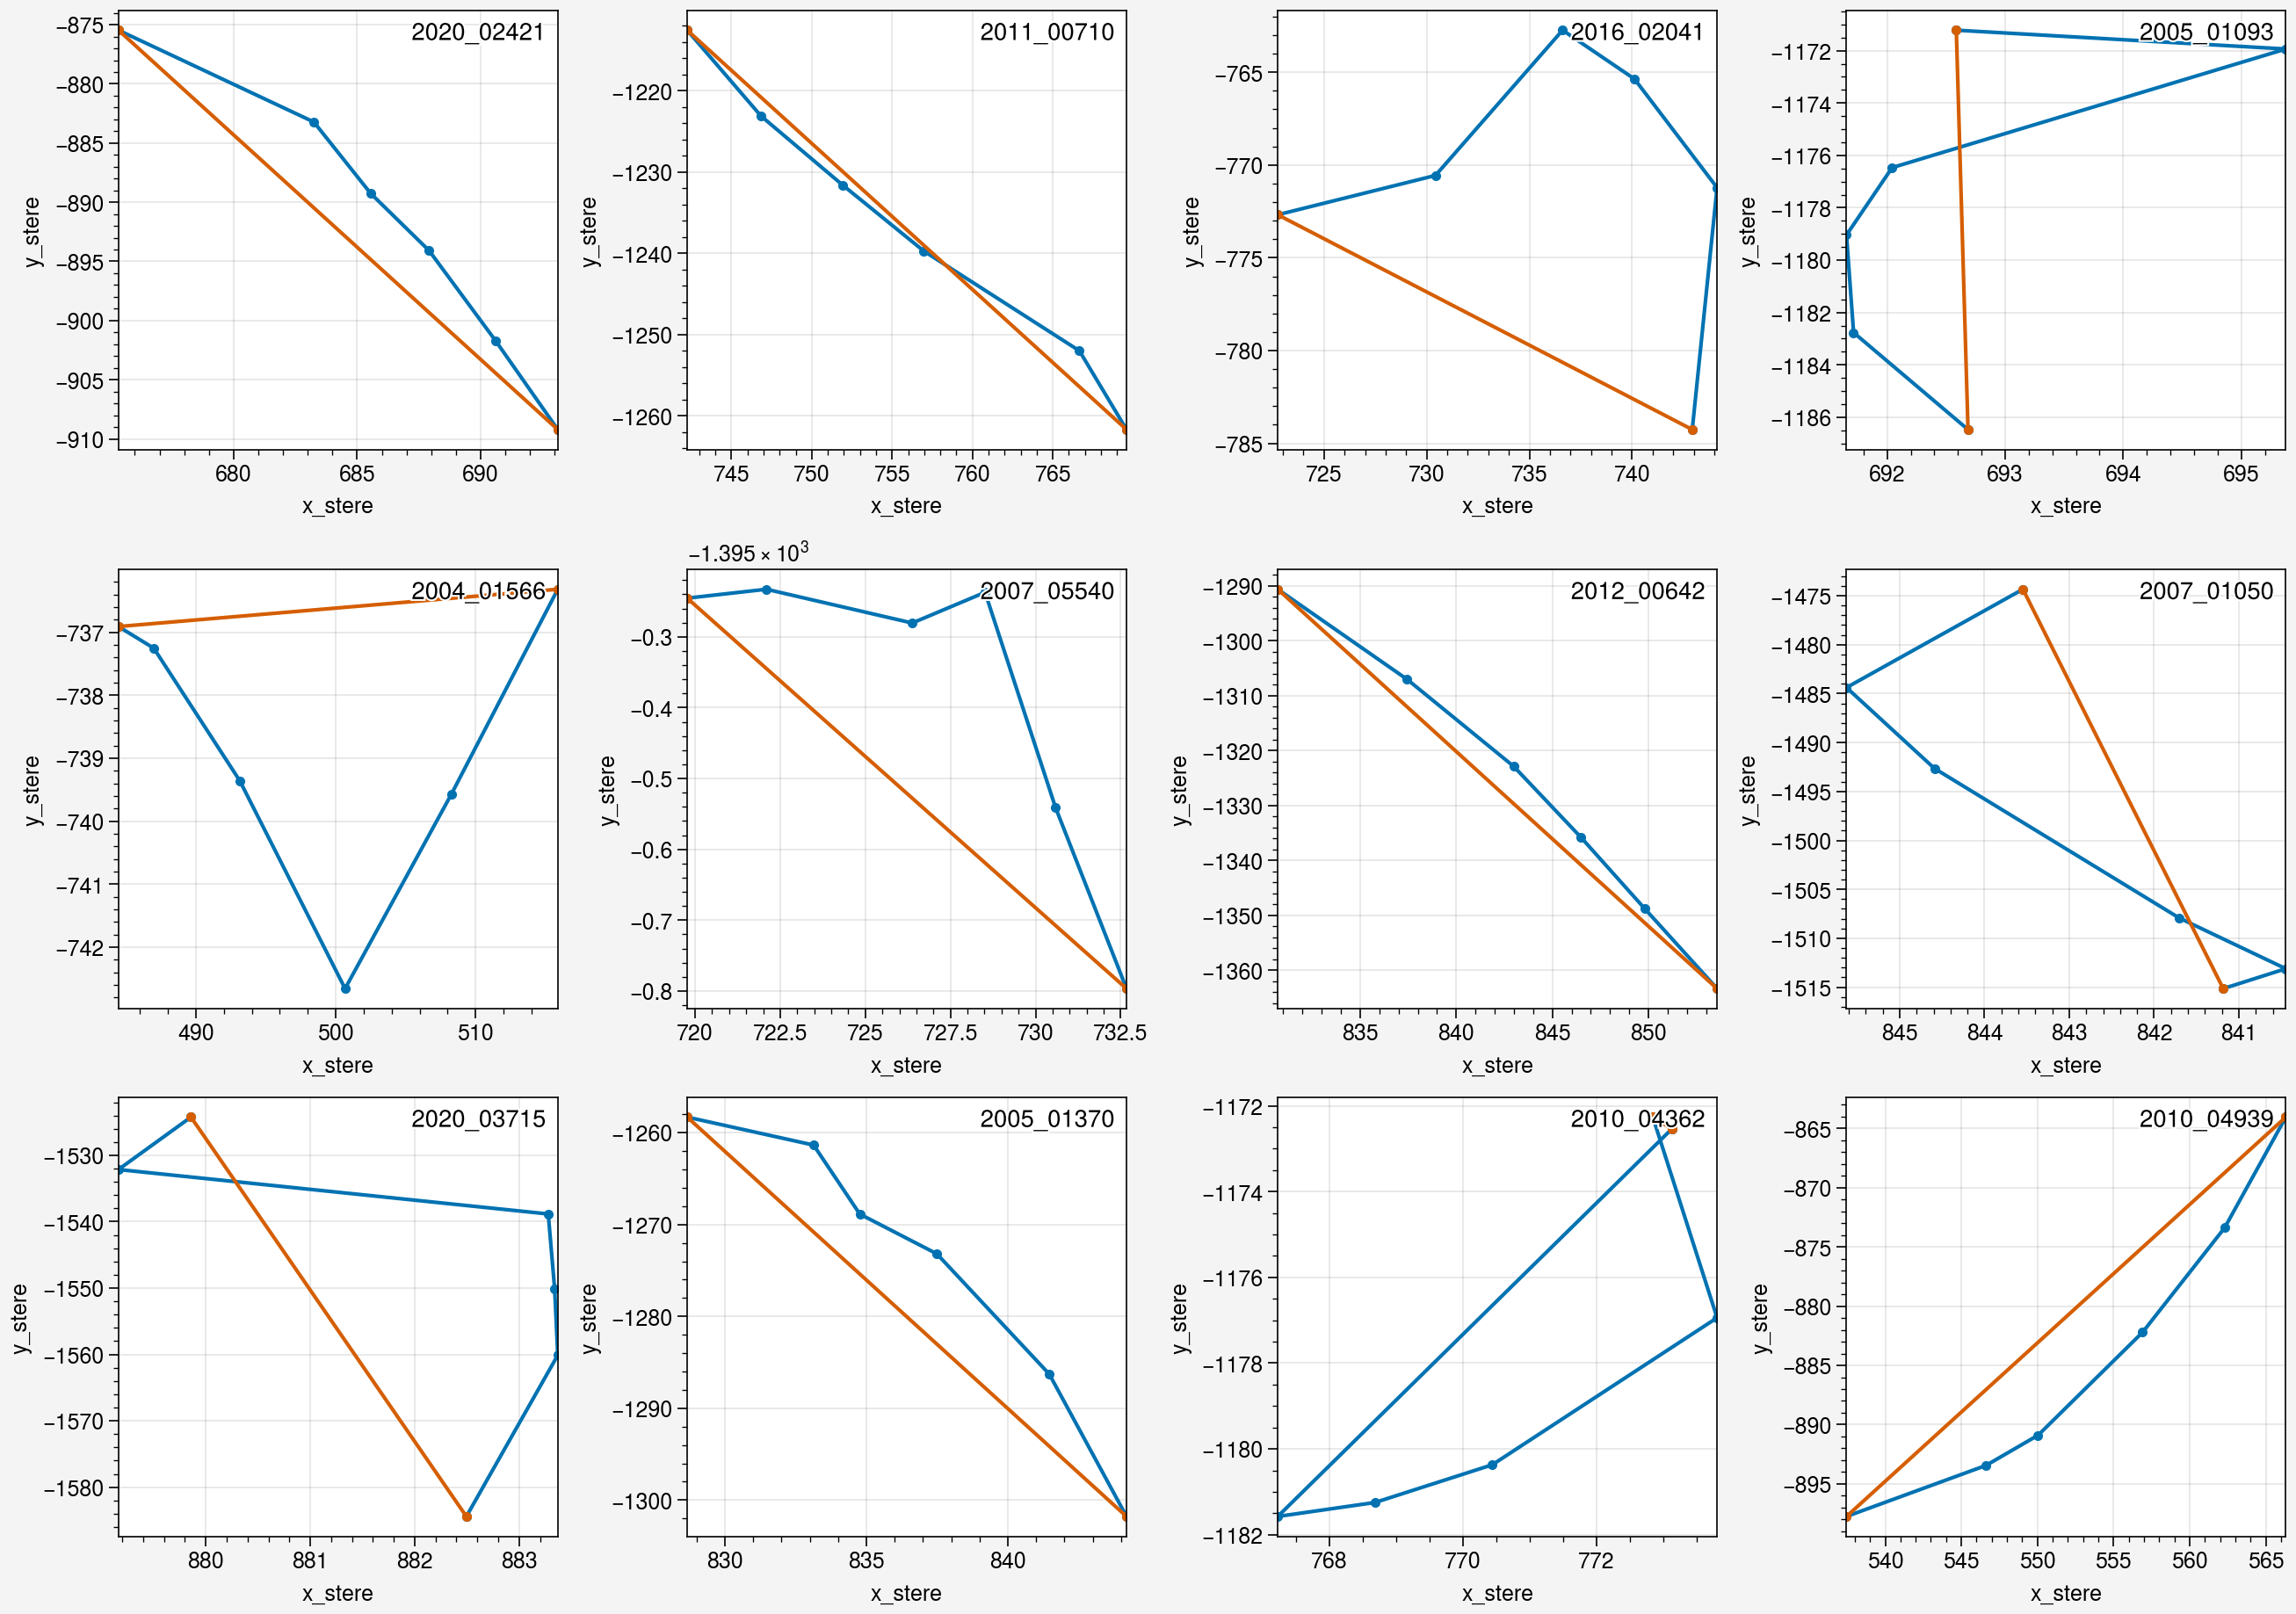

In [14]:
fig, axs = pplt.subplots(ncols=4, nrows=3, share=False)
for ax in axs:
    f_id = df_updated.sample(1).floe_id.values[0]
    df_test = df_updated.loc[df_updated.floe_id == f_id]
    
    ax.plot(df_test.x_stere/1e3, df_test.y_stere/1e3, marker='.')
    ax.plot([df_test.x_stere.values[0]/1e3, df_test.x_stere.values[-1]/1e3],
            [df_test.y_stere.values[0]/1e3, df_test.y_stere.values[-1]/1e3], marker='.')
    ax.format(urtitle=f_id)

In [15]:
df_test = df_ift.loc[df_ift.floe_id == '2016_02041']

<a list of 1 Line2D objects>

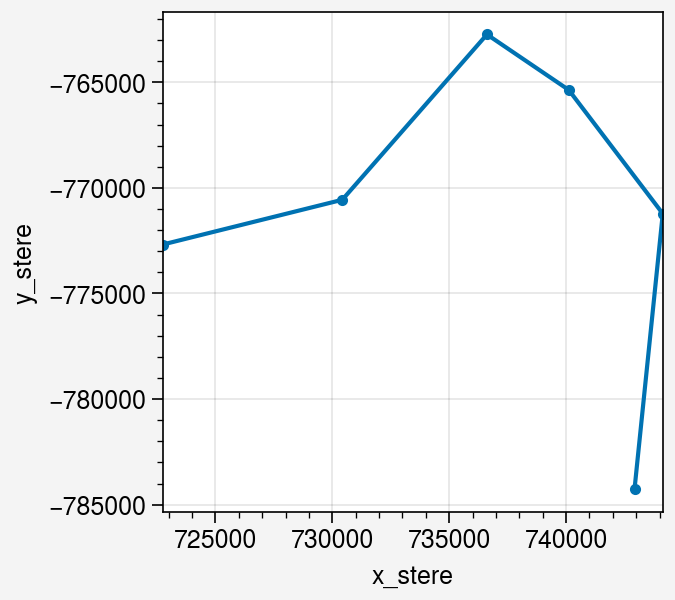

In [18]:
fig, ax = pplt.subplots()
ax.plot(df_test.x_stere, df_test.y_stere, marker='.')

In [24]:
df_test.area

1323    1973.79310
1324    1982.73700
1325    1769.48000
1326    1712.86053
1327    1673.19526
1328    1613.31498
Name: area, dtype: float64